In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import tree
from keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.neighbors import KNeighborsRegressor
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping
from keras.models import load_model    
%matplotlib inline
%config InlineBackend.figure_format = 'svg'    
sns.set()
warnings.filterwarnings('ignore')
random_seed = 100

Using TensorFlow backend.


In [2]:
df = pd.read_csv('houses_dataset.csv', index_col = 'Id')
df = df._get_numeric_data()
df = df.dropna(axis='columns')
df_rows = df.shape[0]
zero_precents = df.astype(bool).apply(lambda x: ~x).sum(axis = 0) / df_rows
zero_columns_labels = list(zero_precents[zero_precents > 0.333].index)
df = df.drop(zero_columns_labels, axis = 1)
df = df.drop(['KitchenAbvGr'], axis = 1)
df.head(10)

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,BedroomAbvGr,TotRmsAbvGrd,GarageCars,GarageArea,MoSold,YrSold,SalePrice
Id,,,,,,,,,,,,,,,,,,,
1,60,8450,7,5,2003,2003,706,150,856,856,1710,2,3,8,2,548,2,2008,208500
2,20,9600,6,8,1976,1976,978,284,1262,1262,1262,2,3,6,2,460,5,2007,181500
3,60,11250,7,5,2001,2002,486,434,920,920,1786,2,3,6,2,608,9,2008,223500
4,70,9550,7,5,1915,1970,216,540,756,961,1717,1,3,7,3,642,2,2006,140000
5,60,14260,8,5,2000,2000,655,490,1145,1145,2198,2,4,9,3,836,12,2008,250000
6,50,14115,5,5,1993,1995,732,64,796,796,1362,1,1,5,2,480,10,2009,143000
7,20,10084,8,5,2004,2005,1369,317,1686,1694,1694,2,3,7,2,636,8,2007,307000
8,60,10382,7,6,1973,1973,859,216,1107,1107,2090,2,3,7,2,484,11,2009,200000
9,50,6120,7,5,1931,1950,0,952,952,1022,1774,2,2,8,2,468,4,2008,129900


## Correlation to Sale-Price

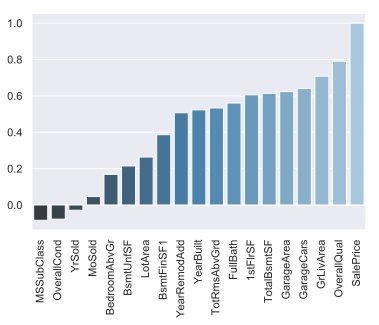

In [3]:
correlation = df.corr()['SalePrice'].sort_values()
dd = pd.DataFrame(correlation)
chart = sns.barplot(correlation.index, correlation.values, palette="Blues_d")
_ = chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

In [4]:
top_8_cats = abs(df.corr())['SalePrice'].sort_values(ascending=False)[1:(1+8)]
for cat in top_8_cats.index:
    print(cat)
data = df[list(top_8_cats.index) + ["SalePrice"]]

OverallQual
GrLivArea
GarageCars
GarageArea
TotalBsmtSF
1stFlrSF
FullBath
TotRmsAbvGrd


## Visualization

In [5]:
_ = sns.pairplot(data=data, y_vars=['SalePrice'], x_vars=data.columns, kind="reg", diag_kind="kde", plot_kws={'line_kws':{'color':'purple'}, 'scatter_kws': {'alpha': 0.2}})

# Correlation Heatmap

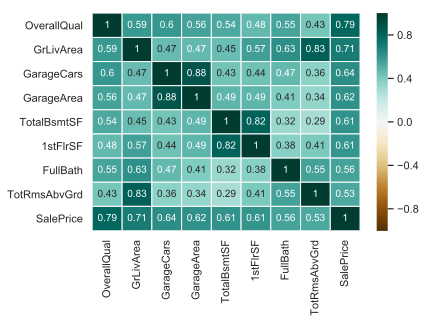

In [6]:
_ = sns.heatmap(data.corr(), cmap="BrBG", linewidths = 1, vmin = -1, vmax = 1, annot = True)

# Neural Network Training

In [7]:
test_precent = 0.15
train_precent = 1.0 - test_precent
train_data = data.sample(frac=train_precent, random_state=random_seed)
test_data = data.drop(train_data.index)

In [8]:
train_stats = train_data.describe().T
def normalize(x):
    result = x.copy()
    for feature_name in x.columns:
        max_value = x[feature_name].max()
        min_value = x[feature_name].min()
        result[feature_name] = (x[feature_name] - min_value) / (max_value - min_value)
    return result
normalized_train_data = normalize(train_data)
normalized_test_data = normalize(test_data)

In [9]:
train_x = normalized_train_data.drop('SalePrice', axis = 1)
train_y = normalized_train_data['SalePrice']
test_x = normalized_test_data.drop('SalePrice', axis = 1)
test_y = normalized_test_data['SalePrice']

In [10]:
def build_fully_NN_model(train):
    input_layer    = Input(shape=(train.shape[1],))
    hidden_layer_1 = Dense(8, activation=tf.nn.relu)(input_layer)
    hidden_layer_2 = Dense(8, activation=tf.nn.relu)(hidden_layer_1)
    output_layer   = Dense(1)(hidden_layer_2)
   
    model = Model(input=[input_layer], output=[output_layer])
    last_layer_model = Model(input=[input_layer], output=[hidden_layer_2])
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    

    return model, last_layer_model

In [11]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

def trainModel(model, X, Y):
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=50)
    mc = ModelCheckpoint('best_nn_model.nn', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
    history = model.fit(X, Y, epochs=400, validation_split = 0.33, verbose=0, callbacks=[PrintDot(), es, mc])
    model = load_model('best_nn_model.nn')
    return history, model

In [12]:
fully_NN_model, last_layer_NN_model = build_fully_NN_model(train_x)
fully_NN_history, fully_NN_model = trainModel(fully_NN_model, train_x, train_y)


....................................................................................................
....................................................................................................
......................................................

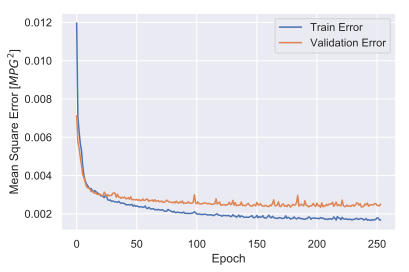

In [13]:
def plot_history(history):    
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch 
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'], label = 'Validation Error')
  #plt.ylim([0,1000])
  plt.legend()
  plt.show()

plot_history(fully_NN_history)

## Test Set

Test Set MSE = 0.008093994110822678


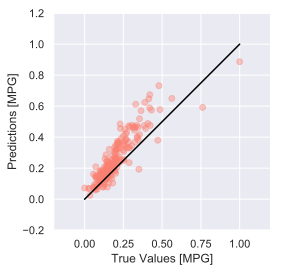

In [14]:
def show_test_predictions(name, model, test_X, test_Y):
    loss, mse = model.evaluate(test_X, test_Y, verbose=0)
    print(name + ' MSE = ' + str(mse))
    test_predictions = model.predict(test_X).flatten()

    plt.scatter(test_Y, test_predictions, alpha = 0.4, color = 'salmon')
    plt.xlabel('True Values [MPG]')
    plt.ylabel('Predictions [MPG]')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([-0.2,1.2])
    plt.ylim([-0.2,1.2])
    _ = plt.plot([0, 1], [0, 1], color = 'black')
show_test_predictions('Test Set', fully_NN_model, test_x, test_y)

## Train Set

Train Set MSE = 0.0019064079970121384


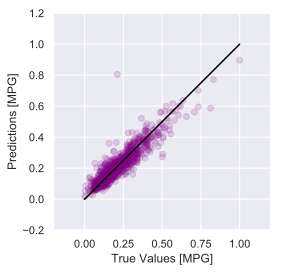

In [15]:
def show_test_predictions(name, model, testX, testY):
    loss, mse = model.evaluate(testX, testY, verbose=0)
    print(name + ' MSE = ' + str(mse))
    test_predictions = model.predict(testX).flatten()

    plt.scatter(testY, test_predictions, alpha = 0.15, color = 'purple')
    plt.xlabel('True Values [MPG]')
    plt.ylabel('Predictions [MPG]')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([-0.2,1.2])
    plt.ylim([-0.2,1.2])
    _ = plt.plot([0, 1], [0, 1], color = 'black')
show_test_predictions('Train Set', fully_NN_model, train_x, train_y)

In [16]:
def evaluate(model, input_data):
    return model.predict(np.array([input_data]))[0][0]

def copy_and_add(data_list, dim_1, amount_1, dim_2, amount_2):
    data_list = data_list.copy()
    data_list[dim_1] += amount_1
    data_list[dim_2] += amount_2
    return data_list

def get_second_derivative(model, input_data, dim_1, dim_2):
    eps = 0.02
    f_pp = evaluate(model, copy_and_add(input_data, dim_1, eps, dim_2, eps))
    f_mm = evaluate(model, copy_and_add(input_data, dim_1, -eps, dim_2, -eps))
    f_mp = evaluate(model, copy_and_add(input_data, dim_1, -eps, dim_2, eps))
    f_pm = evaluate(model, copy_and_add(input_data, dim_1, eps, dim_2, -eps))
    return (f_pp - f_mm) / (4*eps*eps) #- f_mp - f_pm) / (4*eps*eps)

def input_data_options(list_data):
    if (len(list_data) == 8):
        yield list_data
    else:
        for option in [0.3, 0.7]:
            list_data.append(option)
            for inner_res in input_data_options(list_data):
                yield inner_res
            list_data.pop()
hessian = np.zeros((8,8))
abs_hessian = np.zeros((8,8))
i = 0
for input_data in input_data_options([]):
    i += 1
    if (i % 100 == 0):
        print('.', end='')
    for dim_1 in range(8):
        for dim_2 in range(8):
            div = get_second_derivative(fully_NN_model, input_data, dim_1, dim_2)
            hessian[dim_1, dim_2] += div
            abs_hessian[dim_1, dim_2] += abs(div)
input_amount = sum(1 for _ in input_data_options([]))
hessian /= input_amount
abs_hessian /= input_amount

..

# Average of second derivatives ('Hessian')

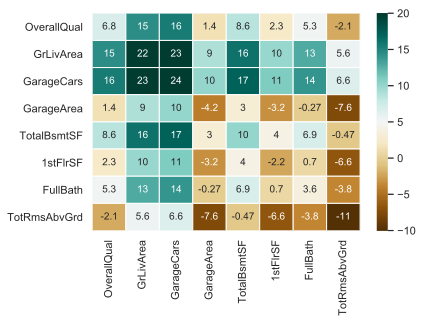

In [17]:
names = data.corr().columns[:8]
hessian_df = pd.DataFrame(hessian, index = names, columns=names)
_ = sns.heatmap(hessian_df, cmap="BrBG", linewidths = 1, vmin = -10, vmax = 20, annot = True)

# Average of absoulte second derivatives

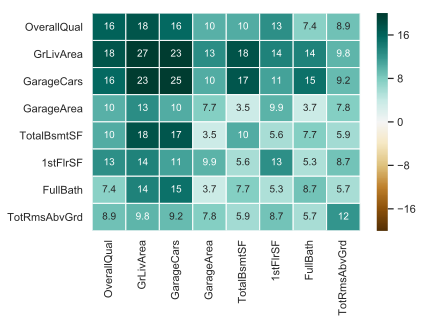

In [18]:
names = data.corr().columns[:8]
abs_hessian_df = pd.DataFrame(abs_hessian, index = names, columns=names)
_ = sns.heatmap(abs_hessian_df, cmap="BrBG", linewidths = 1, vmin = -20, vmax = 20, annot = True)

# Correlation Heatmap

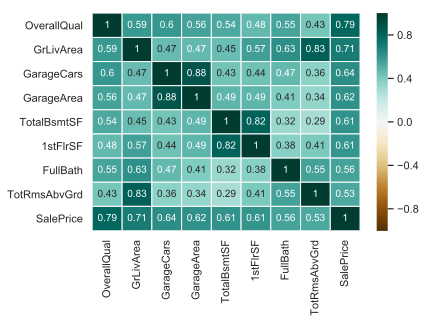

In [19]:
_ = sns.heatmap(data.corr(), cmap="BrBG", linewidths = 1, vmin = -1, vmax = 1, annot = True)